In [76]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from auxFunctions import *

In [77]:
plt.rcParams['figure.figsize']=[8,8]
%config InlineBackend.figure_format = 'retina'

In [78]:
os.chdir("/Volumes/shared/Molekylär Neurobiologi/Castelo-Branco/Mukund/CZI_ADULT/CZI_ATAC/")

In [79]:
ab_dict = {"H3K27ac":"P20057_1004", 
           "H3K27me3":"P20057_1005",
           "H3K4me3":"P20057_1006"
          }

#### Set the antibody before running the notebook!

In [80]:
antibody = "H3K27me3"

## Barcode Filtering

### Read in the barcode statistics files

In [81]:
all_barcode_files = stripReformat("data/barcode_statistics/{}_all_barcodes.txt".format(ab_dict[antibody]))
peak_barcodes_file = stripReformat("data/barcode_statistics/{}_stringent.peak_barcodes.txt".format(ab_dict[antibody]))
metadata_file = "data/{}/singlecell.csv".format(ab_dict[antibody])

In [82]:
all_barcodes = pd.read_csv(all_barcode_files, sep="\t", header=None, index_col=False, names=["all_unique_CT", "barcode"])
#rlxd_peak_bcd = pd.read_csv(rlxd_peak_barcodes_file, sep="\t", header=None, index_col=False, names=["peak_CT","barcode"])
peak_bcd = pd.read_csv(peak_barcodes_file, sep="\t", header=None, index_col=False, names=["peak_CT","barcode"])
metadata = pd.read_csv(metadata_file, sep=",", header=0)

In [83]:
if "NO_BARCODE" in metadata.barcode.values:
    metadata = metadata[metadata.barcode != "NO_BARCODE"]
    
metadata["logUMI"] = np.log10(metadata.passed_filters + 1)
metadata["promoter_ratio_10x"] = (metadata.promoter_region_fragments + 1)/(metadata.passed_filters + 1)
metadata["peak_region_ratio_10x"] = (metadata.peak_region_fragments + 1)/(metadata.passed_filters + 1)

In [84]:

strng_bcd = pd.merge(peak_bcd, all_barcodes)[["barcode", "all_unique_CT", "peak_CT"]]
strng_bcd["peak_ratio_CT"] = strng_bcd.peak_CT / strng_bcd.all_unique_CT
metadata_str = pd.merge(metadata, strng_bcd)
metadata_str["passed_CT"] = "False"

### Set thresholds for filtering

In [85]:
cutoff_reads_min = 10**3
cutoff_read_max = 10**5.5

if antibody == "H3K27ac":
    cutoff_peak_percentage_low = 0.6
    cutoff_peak_percentage_high = 0.95
elif antibody == "H3K4me3":
    cutoff_peak_percentage_low = 0.5
    cutoff_peak_percentage_high = 0.98
elif antibody == "H3K27me3":
    cutoff_peak_percentage_low = 0.4
    cutoff_peak_percentage_high = 0.8

In [86]:
metadata_str.loc[(metadata_str.all_unique_CT > cutoff_reads_min) & 
    (metadata_str.all_unique_CT < cutoff_read_max) &
    (metadata_str.peak_ratio_CT > cutoff_peak_percentage_low) &
    (metadata_str.peak_ratio_CT < cutoff_peak_percentage_high), "passed_CT"] = True

### Plot scatterplot of filtered cells

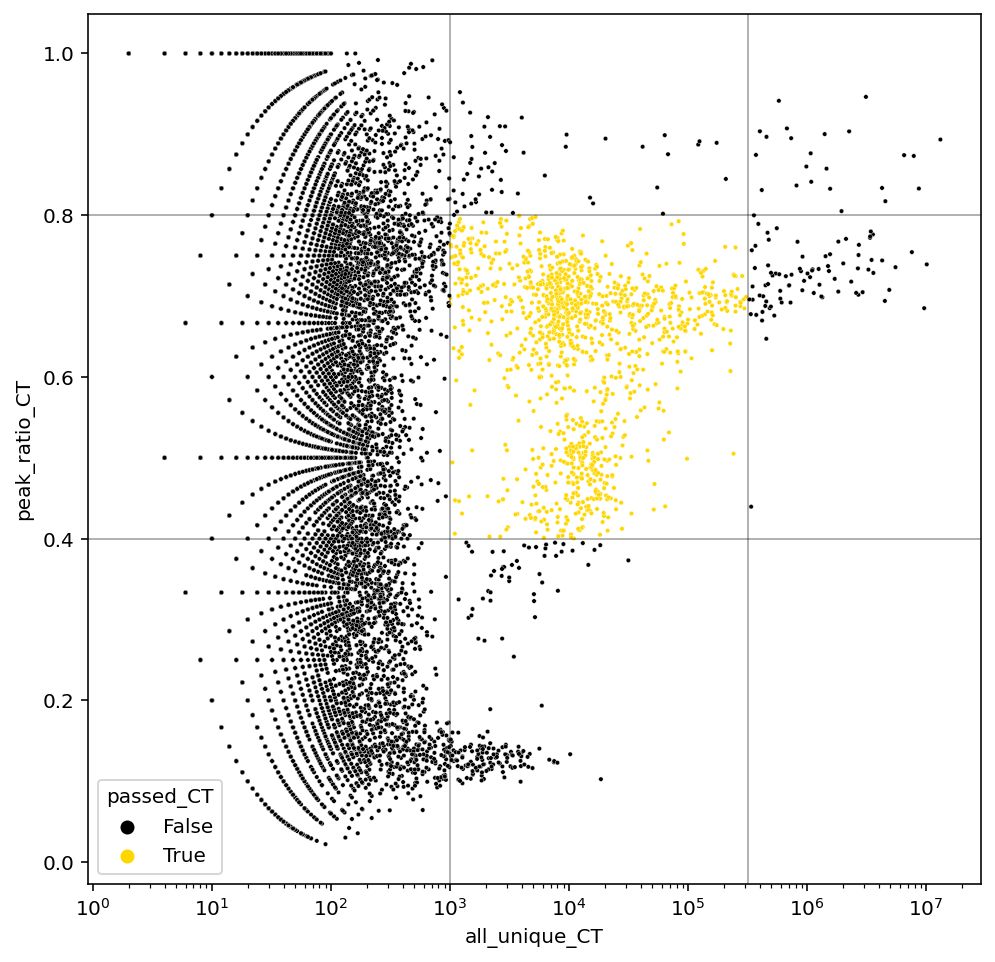

In [87]:
cell_plot = sns.scatterplot(data=metadata_str, x="all_unique_CT", y="peak_ratio_CT", 
                            hue="passed_CT", palette=["black", "gold"], s=5)
cell_plot.set(xscale="log")
plt.axhline(y = cutoff_peak_percentage_low, color='black', linewidth=1, alpha=.3)
plt.axhline(y = cutoff_peak_percentage_high, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_reads_min, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_read_max, color='black', linewidth=1, alpha=.3)

In [88]:
len(metadata_str[metadata_str.passed_CT==True])

1169

### Filter the metadata and the fragments file

In [89]:
passed_CT = metadata_str[metadata_str.passed_CT==True]
filtered_barcode_list = passed_CT.barcode.values.tolist()

In [90]:
passed_CT.to_csv("data/{}/MK_pre_singlecell.csv".format(ab_dict[antibody]), index=False)

In [91]:
passed_CT["all_unique_CT"].mean()

27468.746792130027

In [92]:
FRAGMENTS_PATH = "../../../NGSDATA/scATAC_human_adult_CZI_2/Processed_data/cellranger_output/{}/fragments.tsv.gz".format(ab_dict[antibody])

In [93]:
#%%time
#filterFragments(barcodelist=filtered_barcode_list,
#                fragments=FRAGMENTS_PATH, 
#                out_gz="data/CT_processed_fragments/{}_FILTERED.fragments.tsv".format(ab_dict[antibody]))

Run preArchR.sh from scripts/ before running generating ArrowFiles in ArchR


## Now run ArchR using the filtered Fragments